In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
from scipy import stats

sns.set_style("whitegrid")

In [6]:
df = pd.read_csv('../data/processed/01_cleaned_eu_analysis_data.csv')

In [7]:
df = df.set_index(['geo', 'time'])

In [8]:
df.head(10)


building_permits  construction_prices  gdp_per_capita  \
geo time                                                          
AT  2010               7.4                  1.7         35170.0   
    2011              13.0                  2.9         36740.0   
    2012             -10.4                  2.6         37570.0   
    2013               8.6                  2.4         37890.0   
    2014               1.7                  2.3         38640.0   
    2015               3.8                  1.5         39640.0   
    2016              11.1                  1.9         40690.0   
    2017              10.6                  2.7         41760.0   
    2018             -13.2                  3.7         43360.0   
    2019              10.5                  3.3         44570.0   

          house_price_index  inflation_rate  pop_change  pop_density  \
geo time                                                               
AT  2010           5.992308       90.144167       7.125        105.7   
    2011           5.400000       93.345000       7.125        101.8   
    2012           6.600000       95.745833       5.200        102.3   
    2013           5.000000       97.773333       6.600        102.9   
    2014           3.800000       99.201667       9.000        103.7   
    2015           5.600000      100.000000      13.400        104.9   
    2016           6.700000      100.970833       8.300        106.0   
    2017           5.100000      103.223333       5.600        106.8   
    2018           6.000000      105.411667       4.100        107.1   
    2019           6.000000      106.983333       4.800        107.6   

          price_income_ratio  unemployment_rate  
geo time                                         
AT  2010               86.18                5.2  
    2011               89.63                4.9  
    2012               91.83                5.2  
    2013               96.93                5.7  
    2014               98.82                6.0  
    2015              102.89                6.1  
    2016              106.89                6.5  
    2017              110.01                5.9  
    2018              113.00                5.2  
    2019              117.37                4.8

In [9]:
df.isnull().sum()

building_permits       0
construction_prices    0
gdp_per_capita         0
house_price_index      0
inflation_rate         0
pop_change             0
pop_density            0
price_income_ratio     0
unemployment_rate      0
dtype: int64

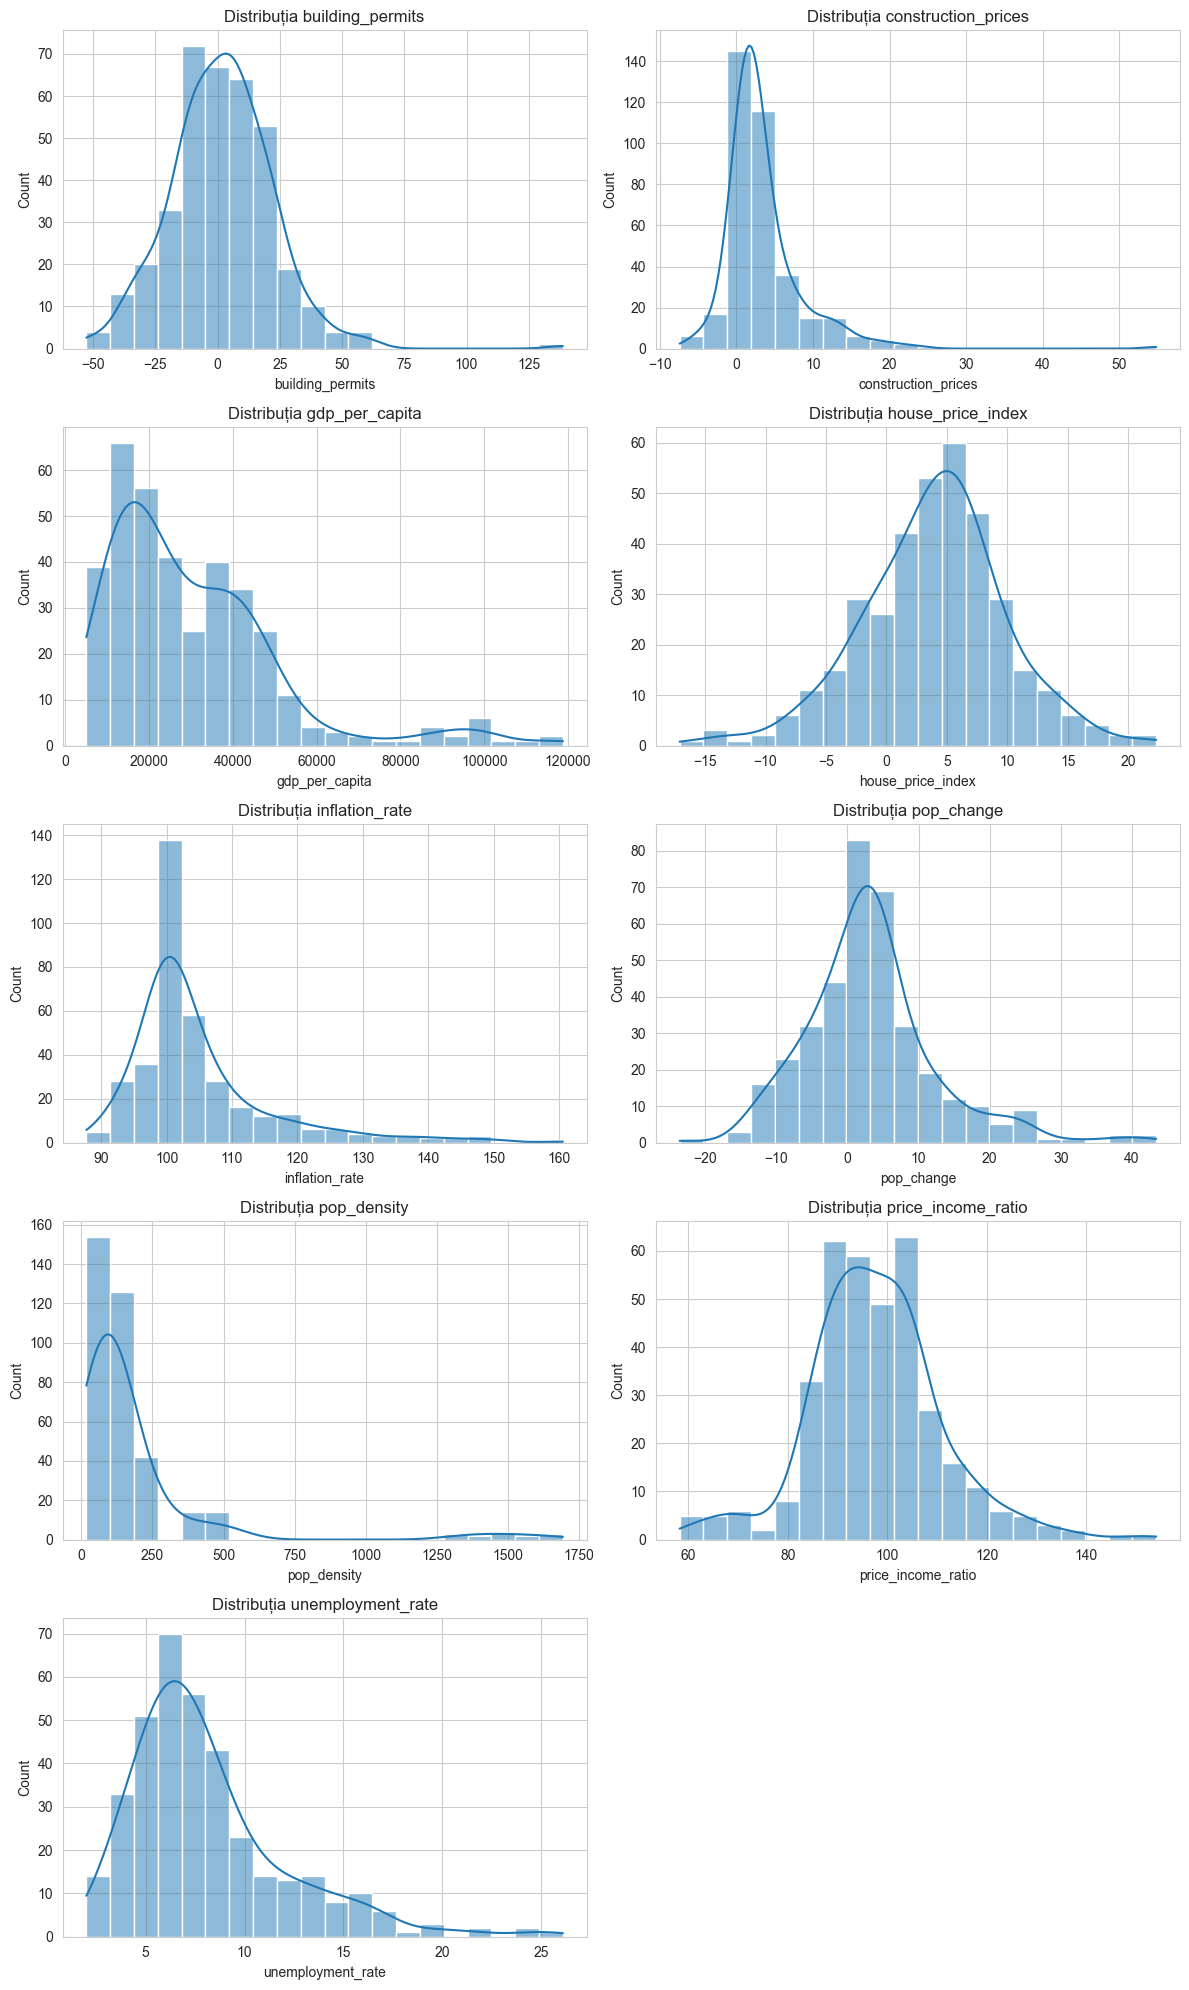

In [10]:
num_vars = len(df.columns)
rows = (num_vars // 2) + (num_vars % 2)  
fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4)) 

axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i]).set_title(f"Distribuția {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


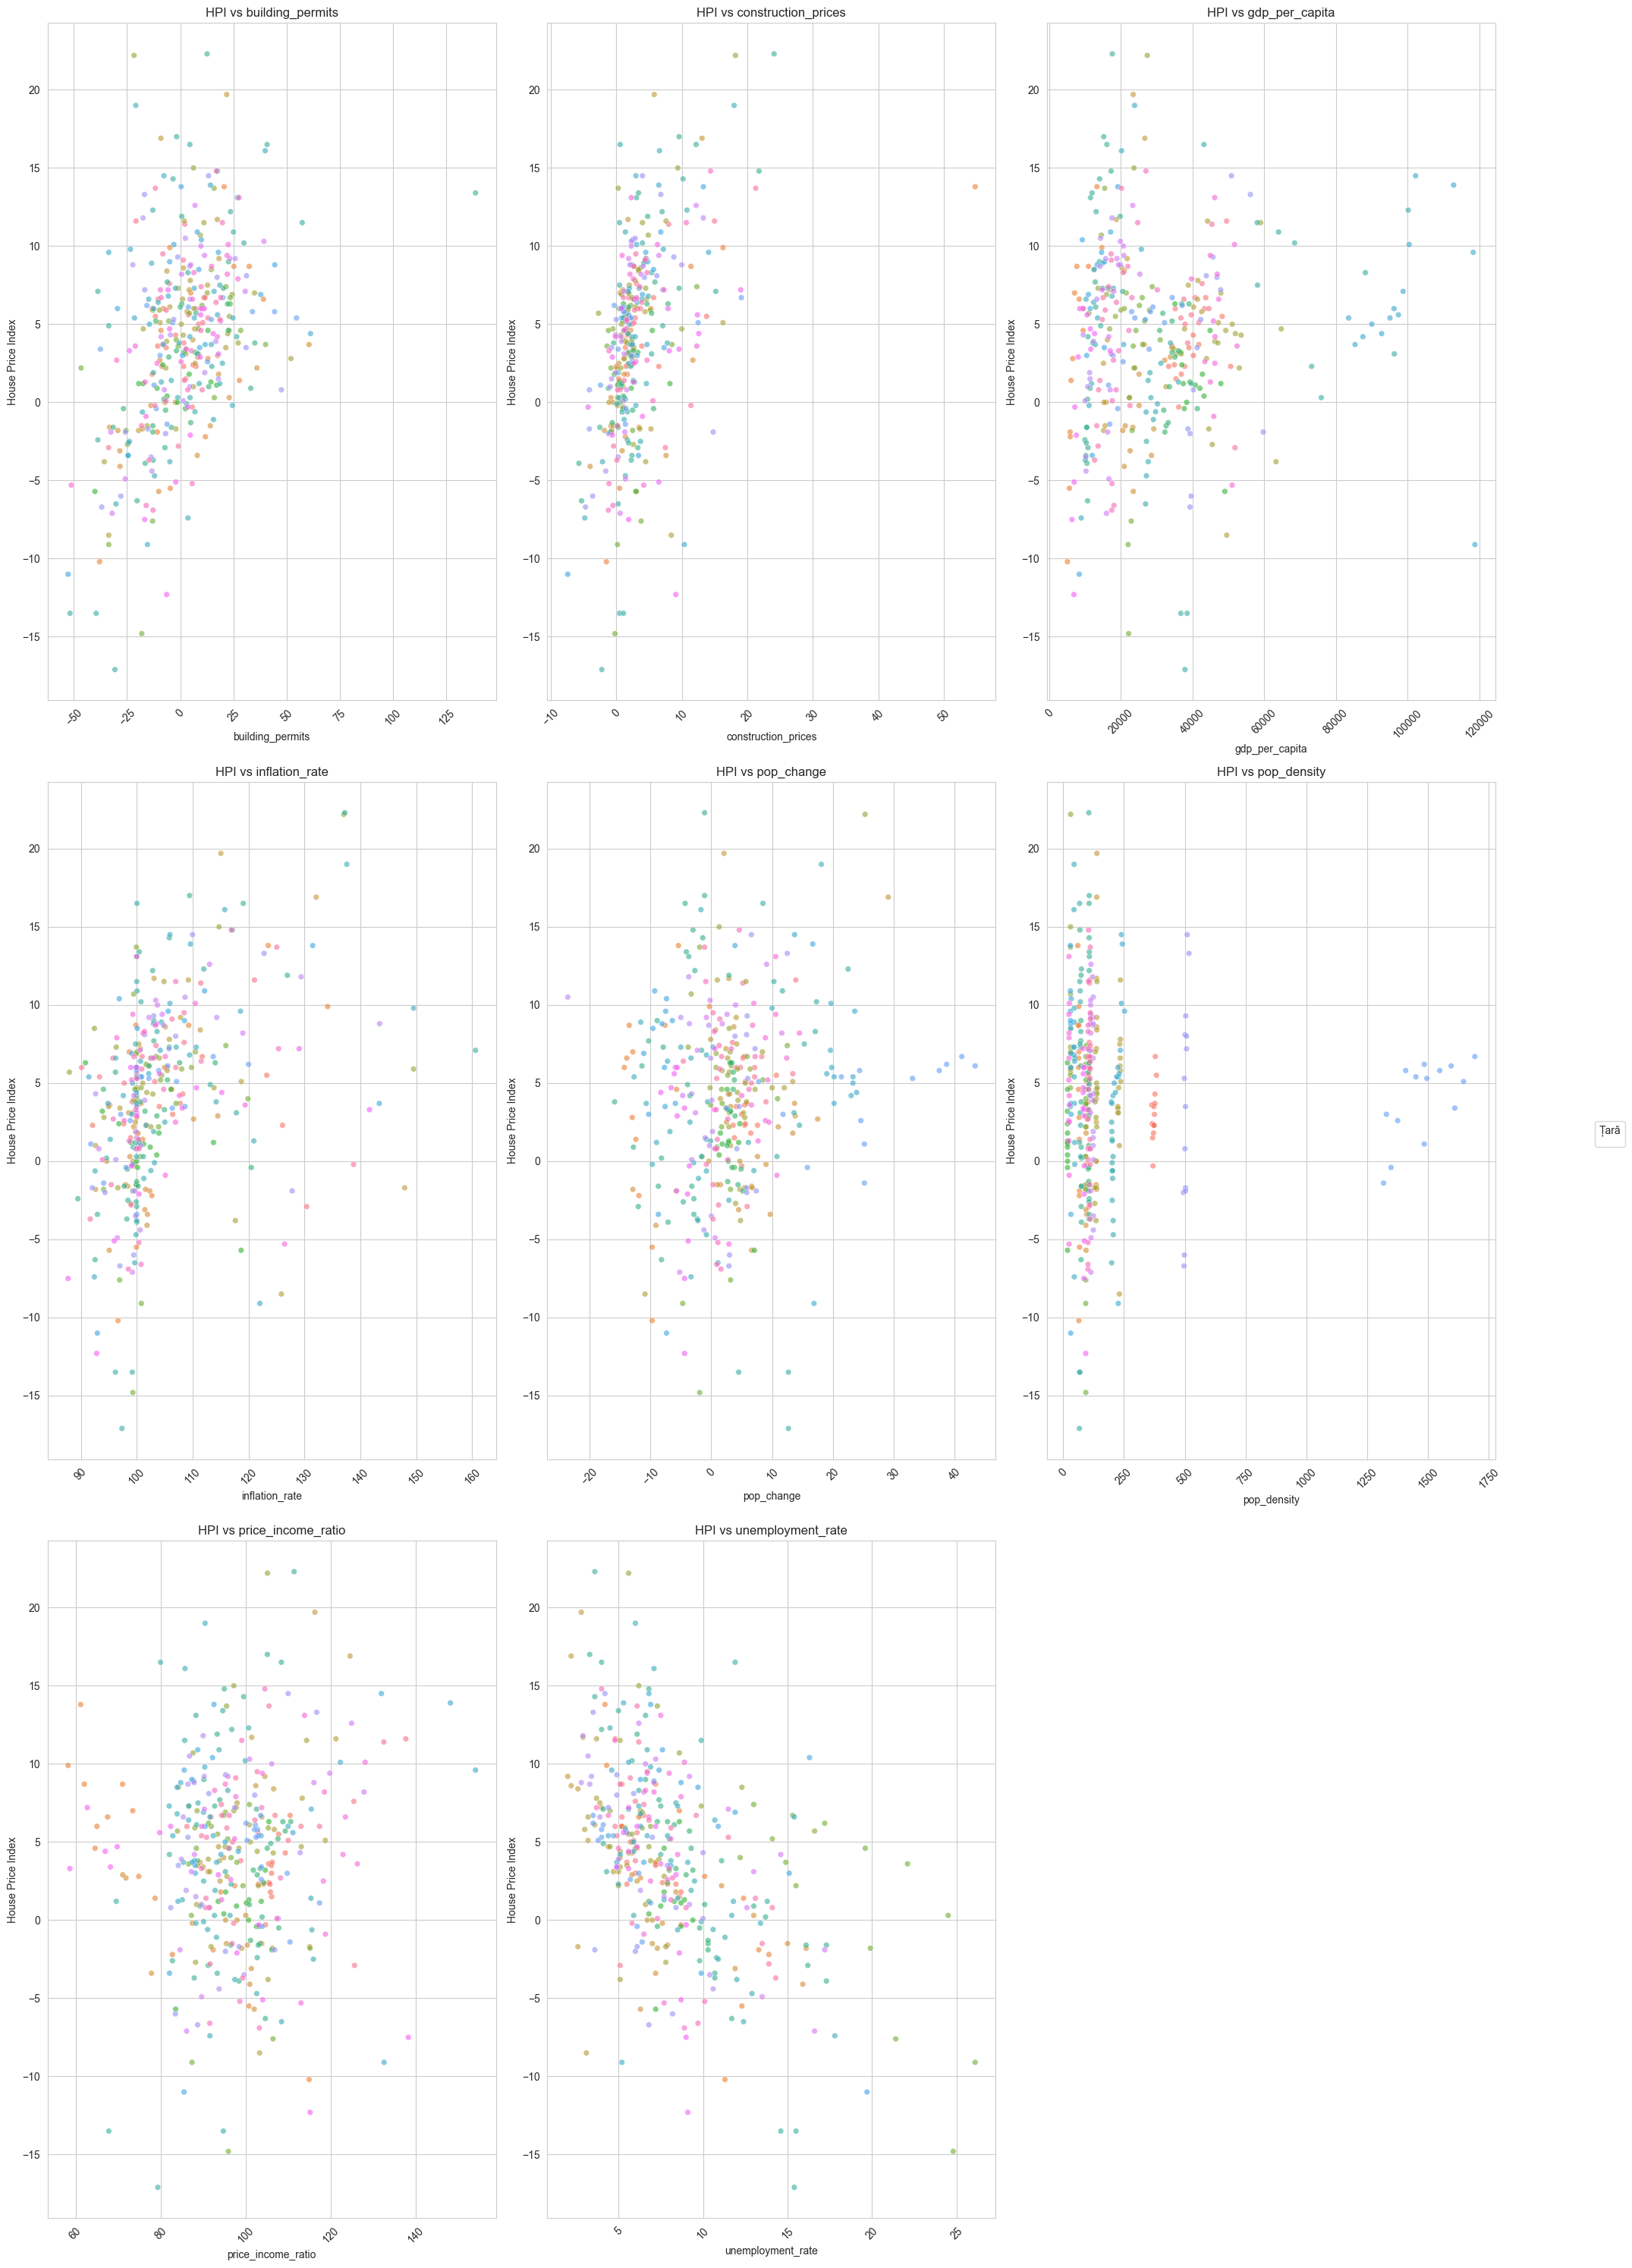

In [11]:
x_cols = [col for col in df.columns if col != "house_price_index"]

fig, axes = plt.subplots(nrows=len(x_cols)//3 + 1, ncols=3, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(x_cols):
    scatter = sns.scatterplot(data=df, x=col, y="house_price_index", hue="geo", alpha=0.6, s=30, ax=axes[i], legend=False)
    axes[i].set_title(f"HPI vs {col}", fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel("House Price Index", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45) 

handles, labels = scatter.get_legend_handles_labels()
fig.legend(handles, labels, title="Țară", bbox_to_anchor=(1.05, 0.5), loc='center left')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


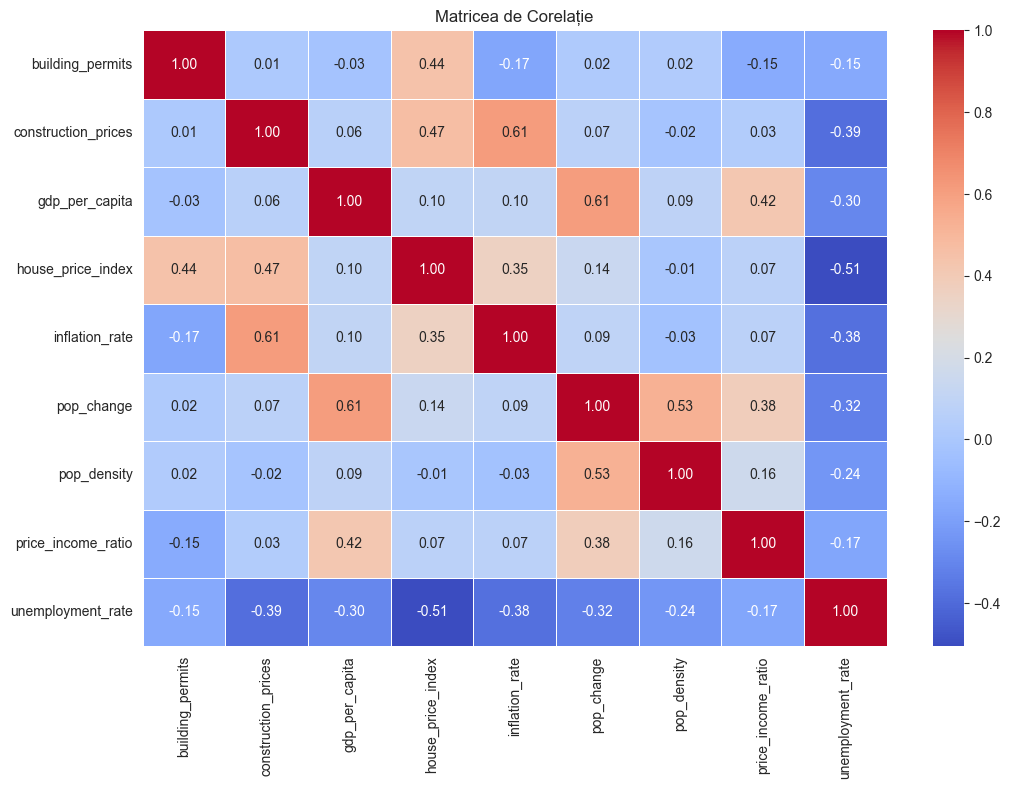

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matricea de Corelație")
plt.show()

In [13]:
X_VIF = df.drop("house_price_index", axis=1)

print("Calculate VIF for the following features:")
print(X_VIF.columns)
print()

vif_data = pd.DataFrame()
vif_data["Feature"] = X_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(X_VIF.values, i) for i in range(X_VIF.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))


Calculate VIF for the following features:
Index(['building_permits', 'construction_prices', 'gdp_per_capita',
       'inflation_rate', 'pop_change', 'pop_density', 'price_income_ratio',
       'unemployment_rate'],
      dtype='object')

               Feature        VIF
6   price_income_ratio  52.661046
3       inflation_rate  52.211305
7    unemployment_rate   6.472306
2       gdp_per_capita   6.319946
4           pop_change   2.768411
5          pop_density   2.260755
1  construction_prices   2.166833
0     building_permits   1.017200


In [14]:
df.drop(["price_income_ratio", "inflation_rate"], axis=1, inplace=True)

In [18]:
X_VIF = df.drop("house_price_index", axis=1)

print("Calculate VIF for the following features:")
print(X_VIF.columns)
print()

vif_data = pd.DataFrame()
vif_data["Feature"] = X_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(X_VIF.values, i) for i in range(X_VIF.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))


Calculate VIF for the following features:
Index(['building_permits', 'construction_prices', 'gdp_per_capita',
       'pop_change', 'pop_density', 'unemployment_rate'],
      dtype='object')

               Feature       VIF
2       gdp_per_capita  3.643960
3           pop_change  2.559609
5    unemployment_rate  2.434643
4          pop_density  1.851461
1  construction_prices  1.330356
0     building_permits  1.007717


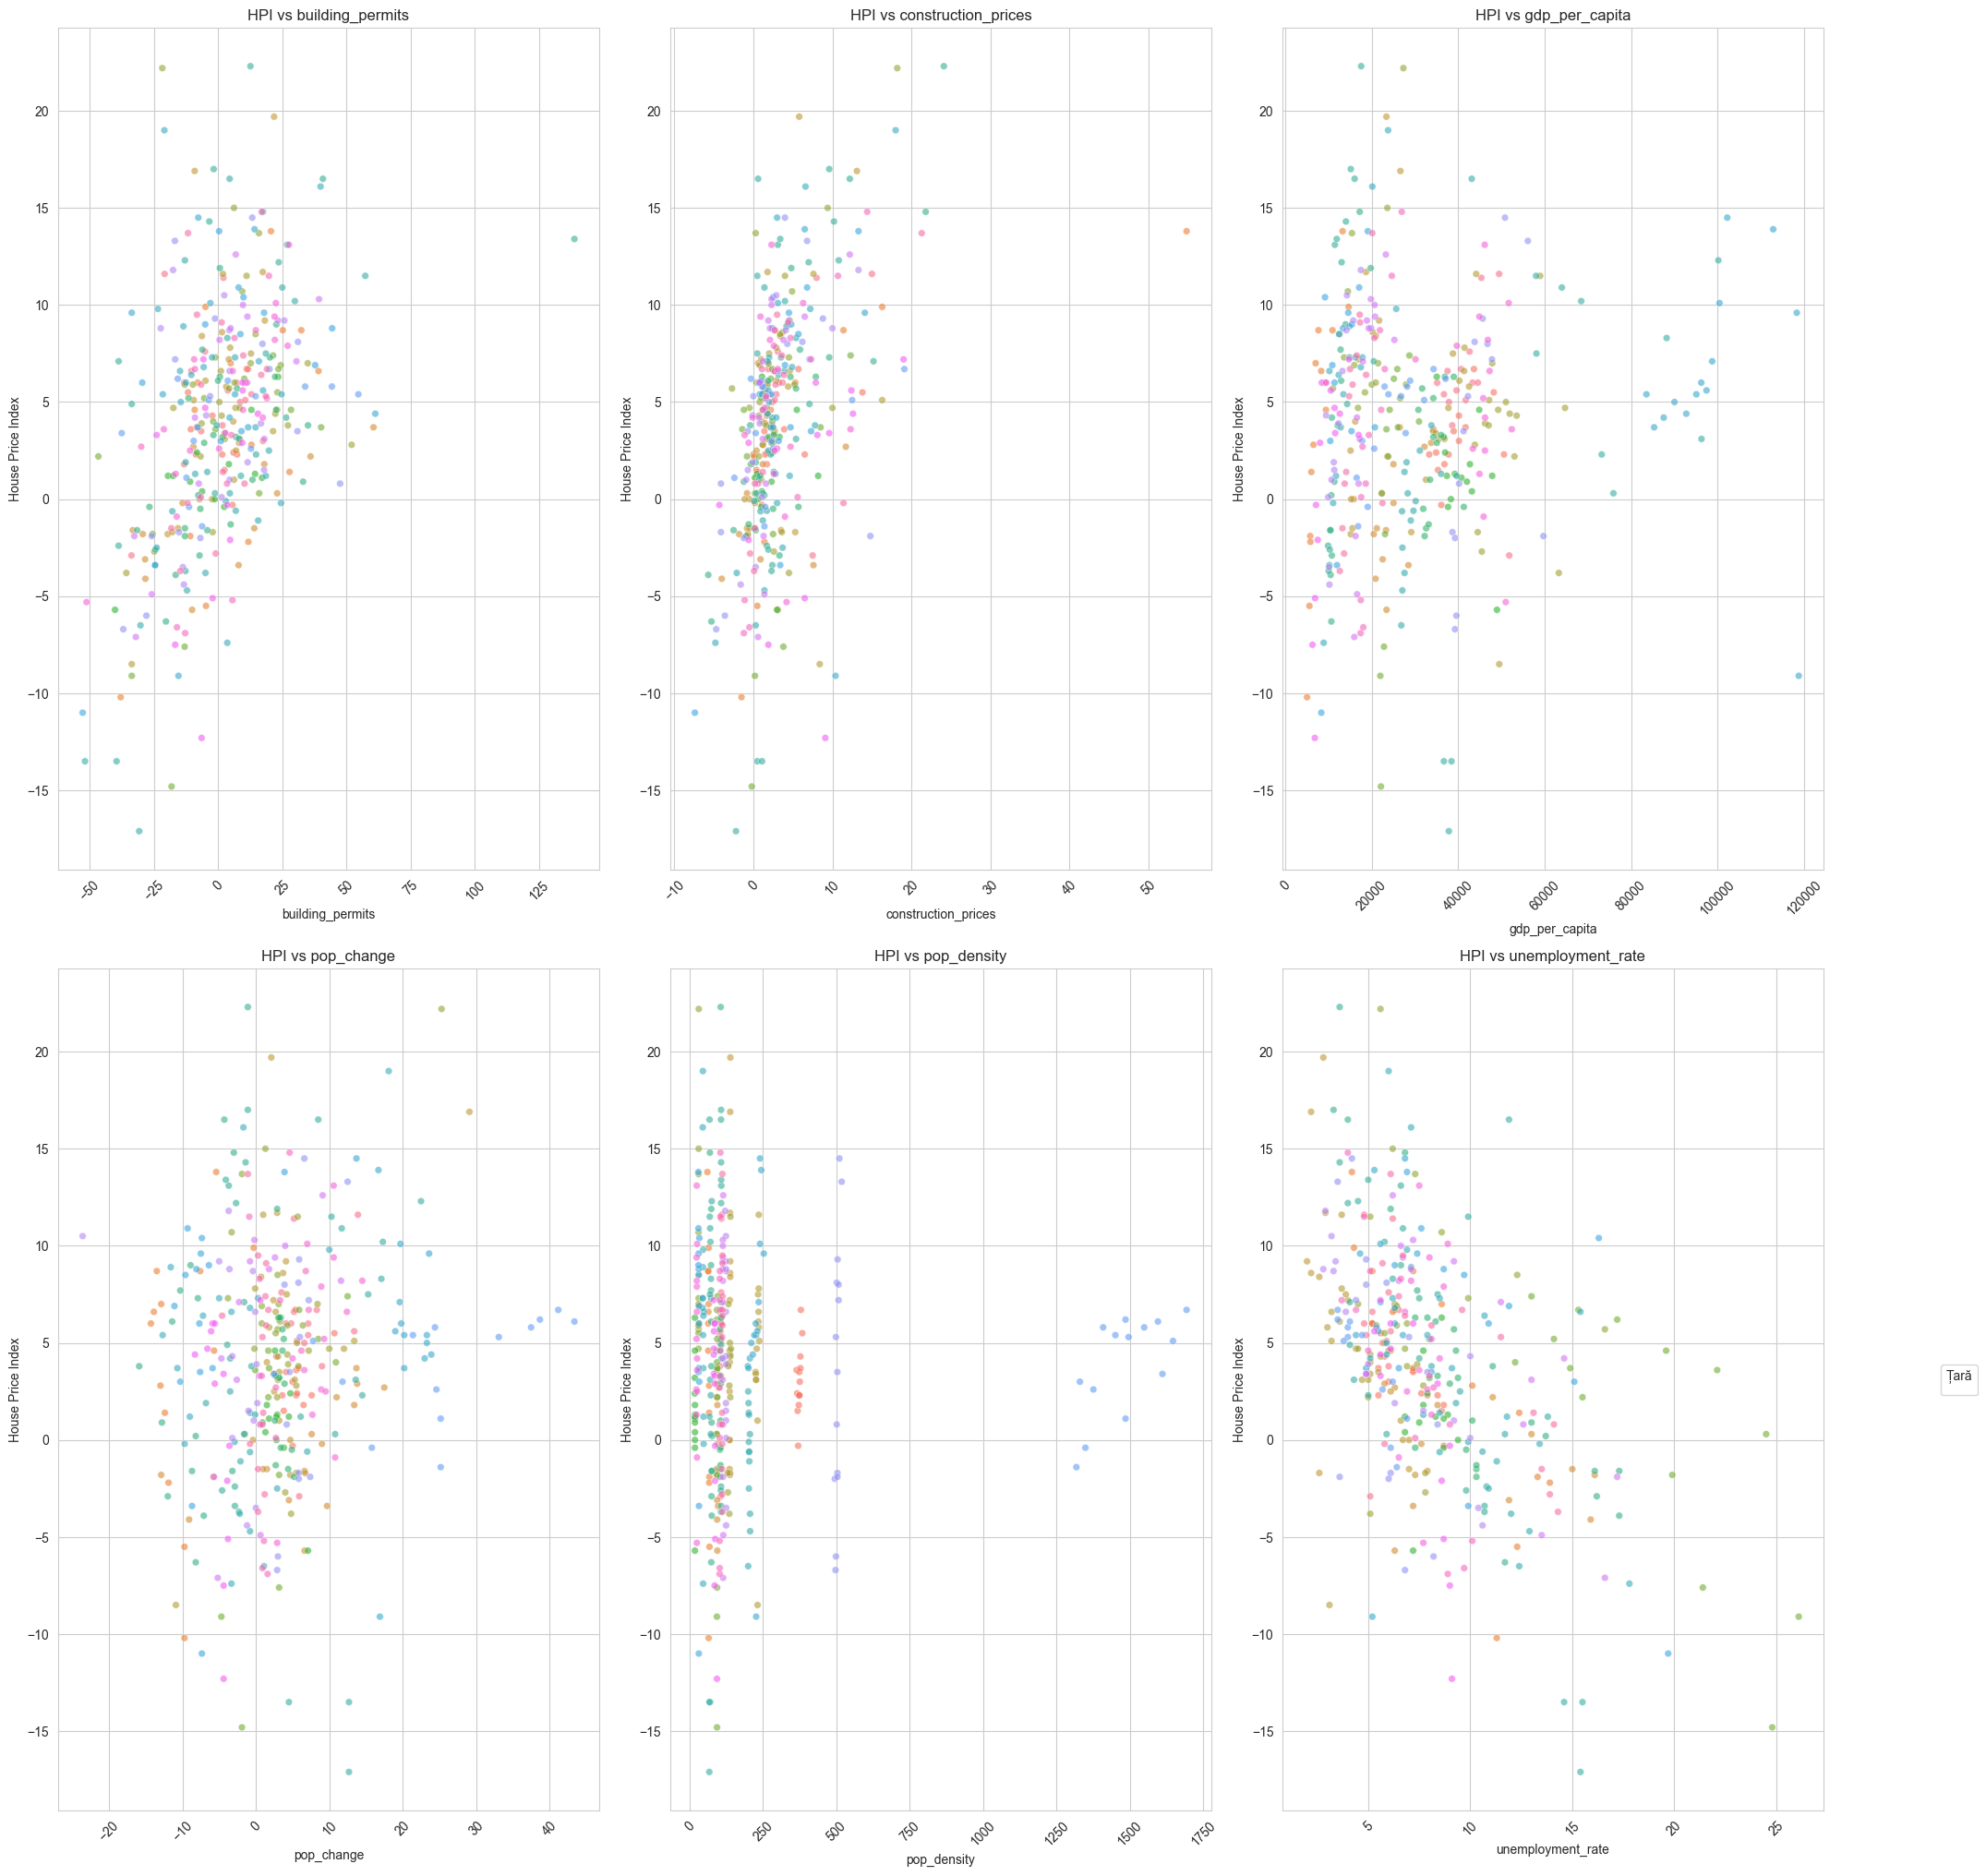

In [15]:
x_cols = [col for col in df.columns if col not in ["geo", "time", "house_price_index"]]

fig, axes = plt.subplots(nrows=len(x_cols)//3 + 1, ncols=3, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(x_cols):
    scatter = sns.scatterplot(data=df, x=col, y="house_price_index", hue="geo", alpha=0.6, s=30, ax=axes[i], legend=False)
    axes[i].set_title(f"HPI vs {col}", fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel("House Price Index", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45) 

handles, labels = scatter.get_legend_handles_labels()
fig.legend(handles, labels, title="Țară", bbox_to_anchor=(1.05, 0.5), loc='center left')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


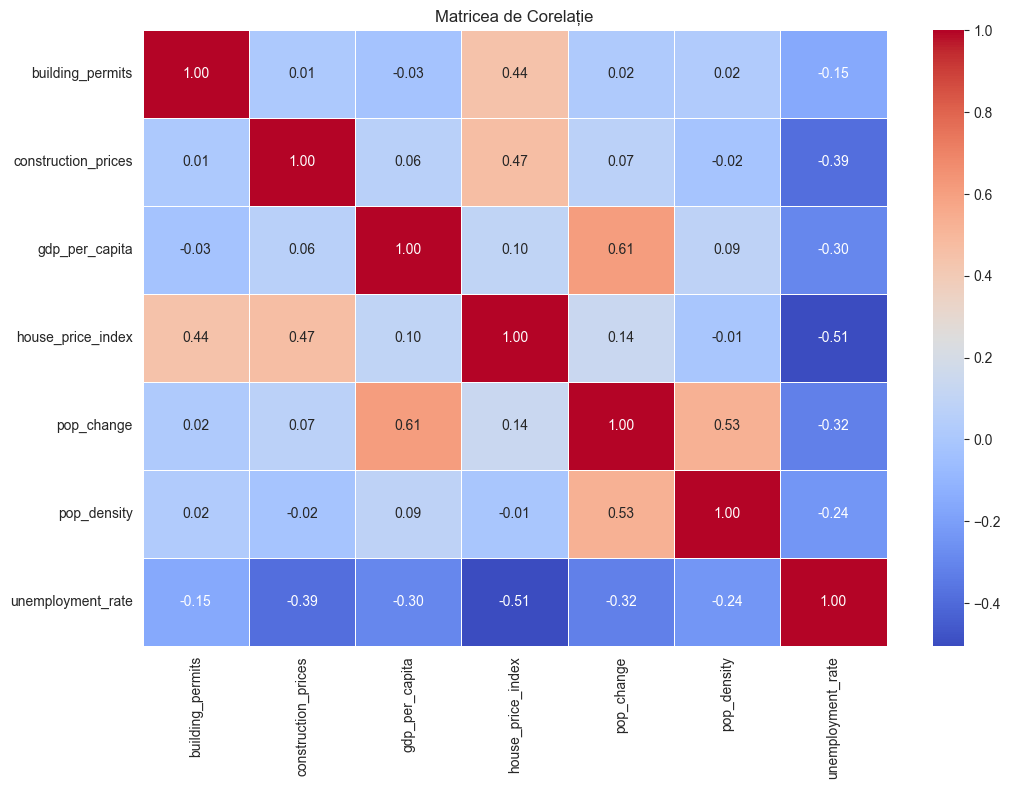

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matricea de Corelație")
plt.show()

In [17]:
df.to_csv('../data/processed/02_eda_cleaned_eu_analysis_data.csv')
print("Data exported to CSV!")

Data exported to CSV!
